# Ideal Parameter Analysis ($\delta=2.25$, $\tau=1.25$, $\alpha=1.95$) ($\alpha$ slightly low)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 2.25
expected_tau=1.25
expected_alpha=1.95

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

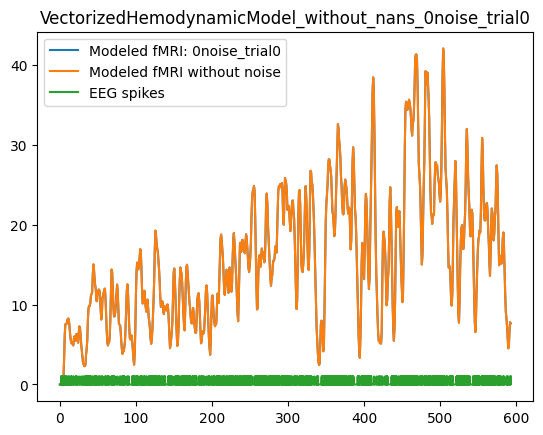

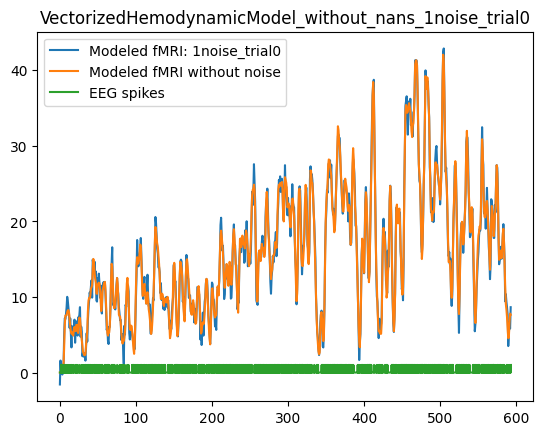

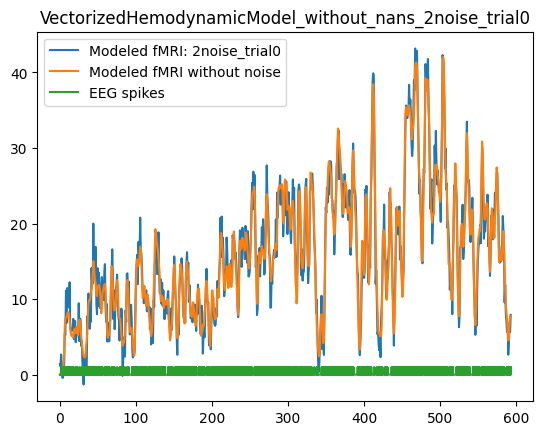

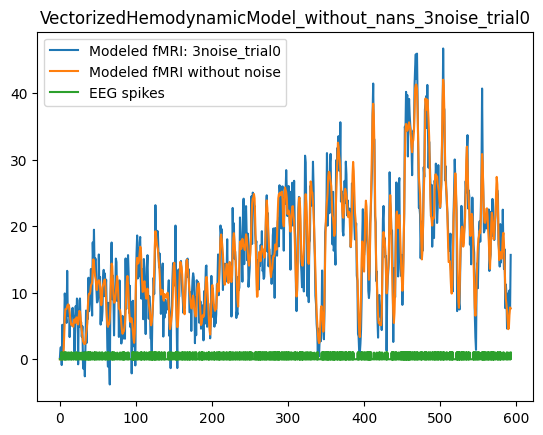

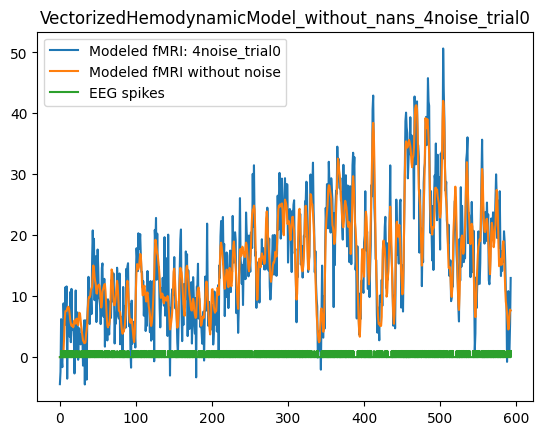

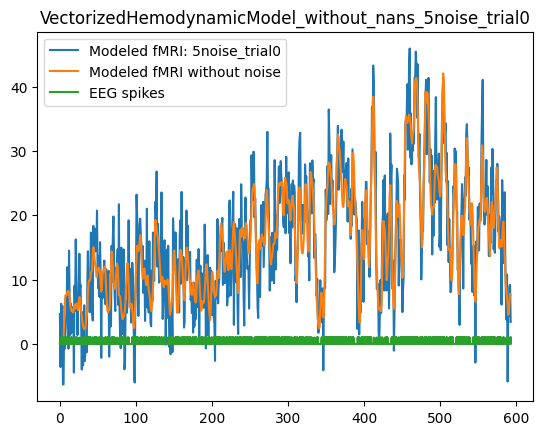

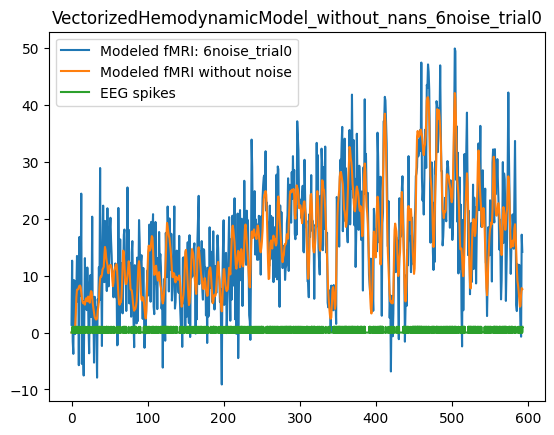

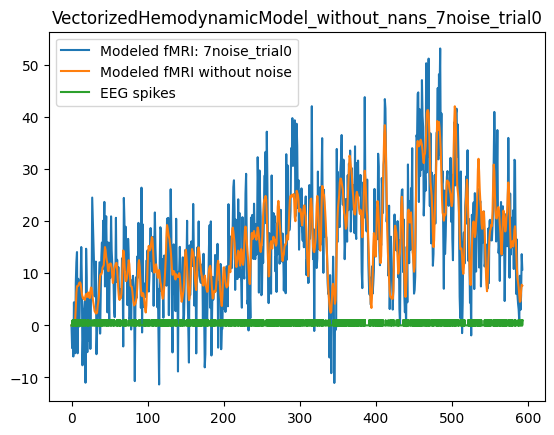

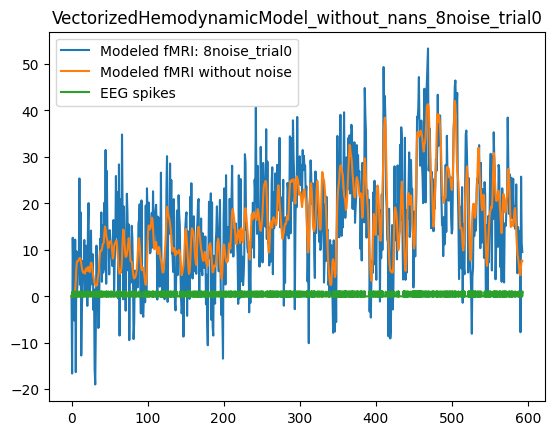

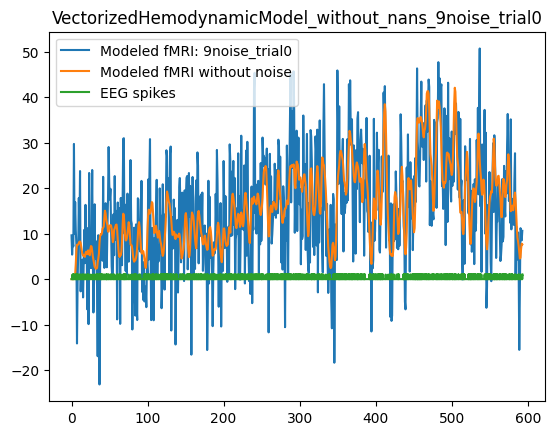

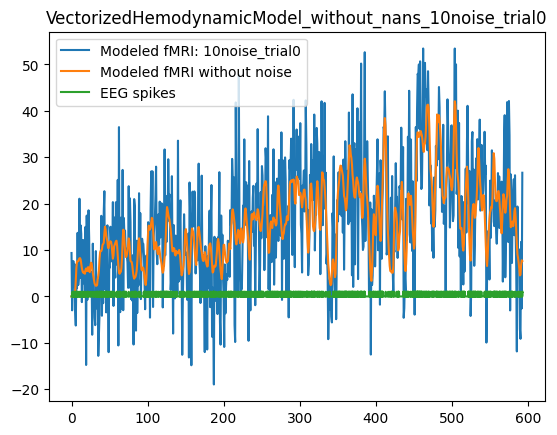

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 2.25, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 1.25, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 1.95, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=2.25, tau=1.25, alpha=1.95


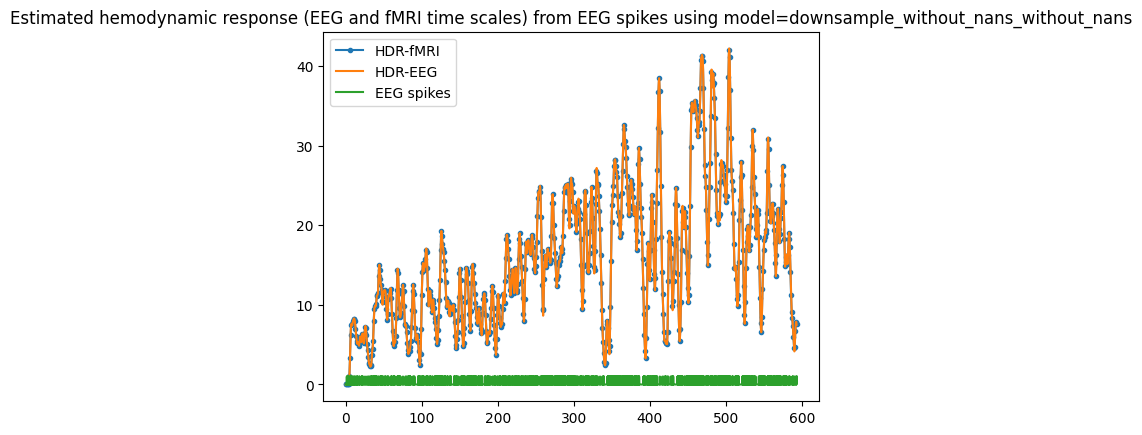

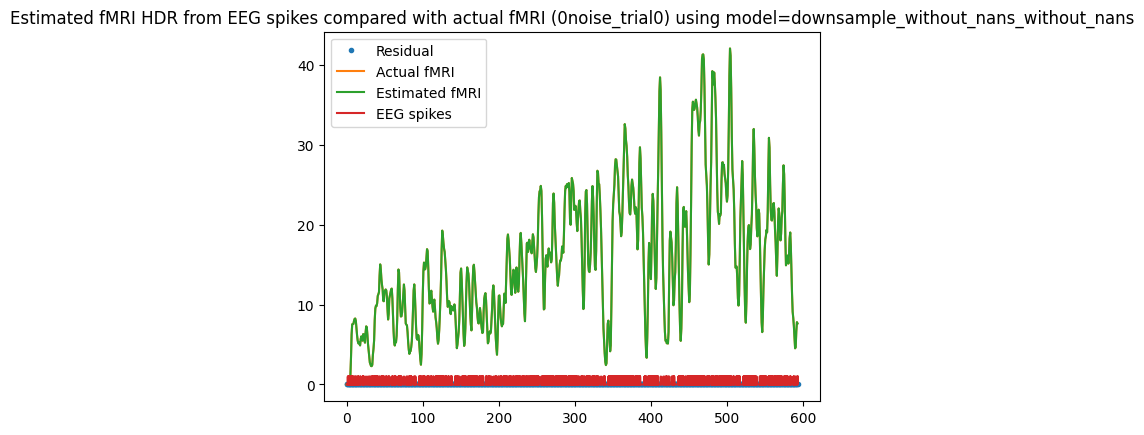

Residual Variance is 0.000000


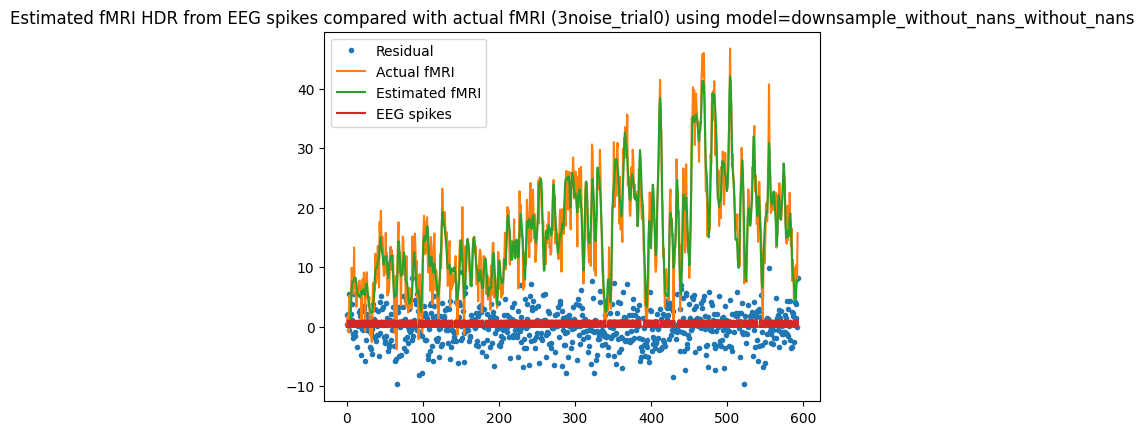

Residual Variance is 9.275897


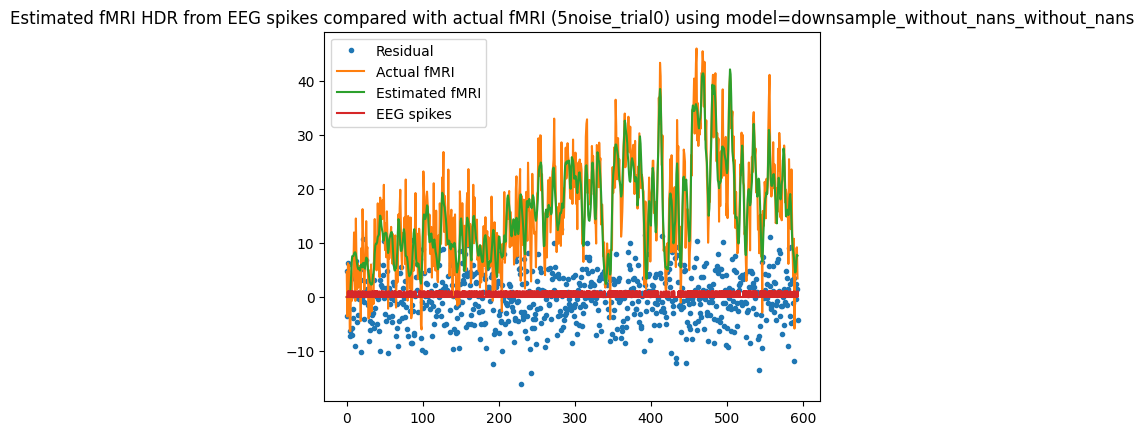

Residual Variance is 23.056791


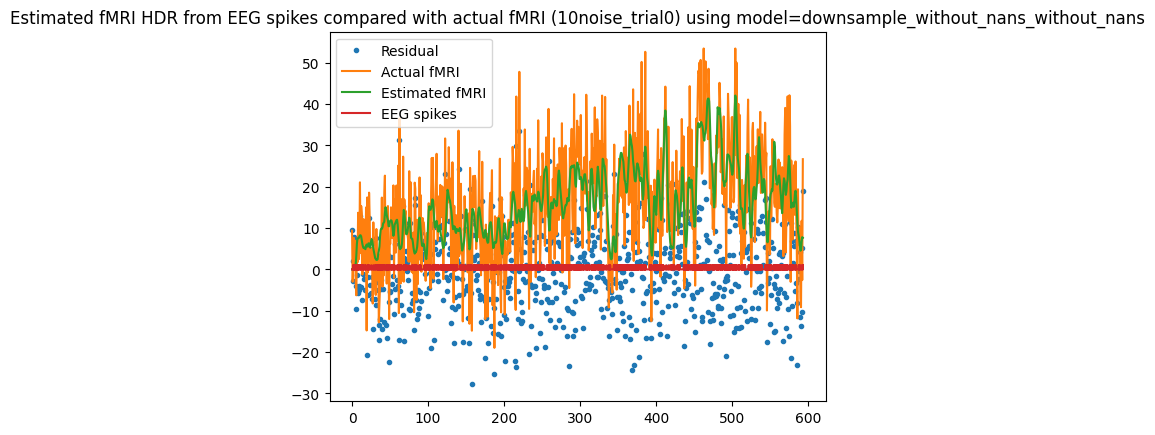

Residual Variance is 99.417025


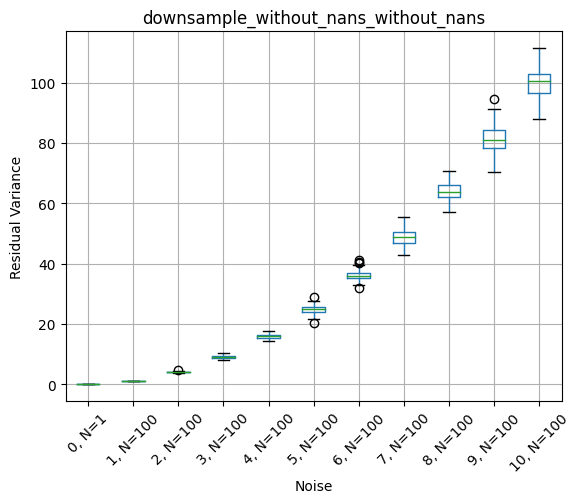

Scoring downsample_without_nans_with_nans delta=2.25, tau=1.25, alpha=1.95


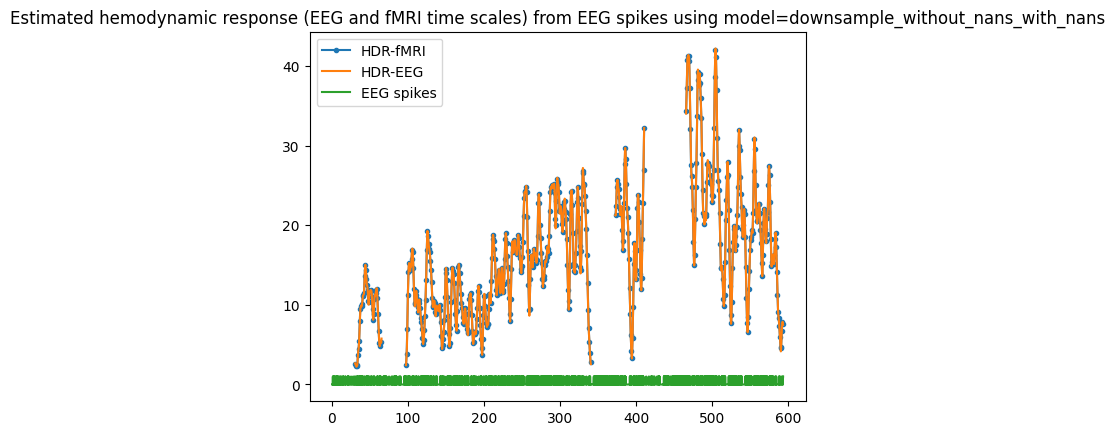

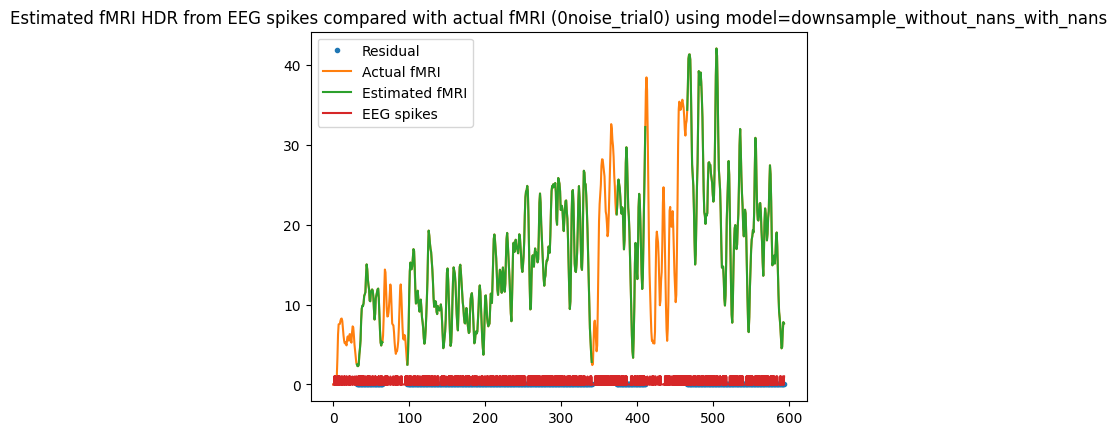

Residual Variance is 0.000000


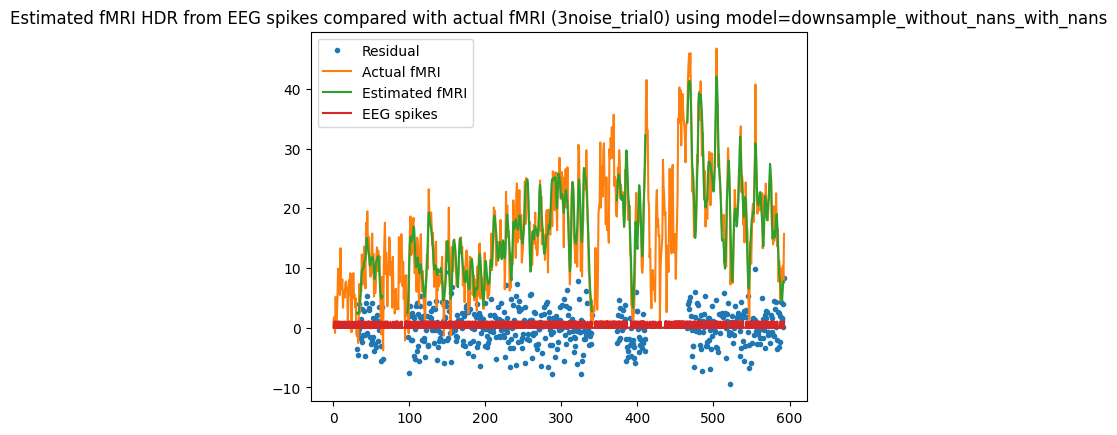

Residual Variance is 8.834351


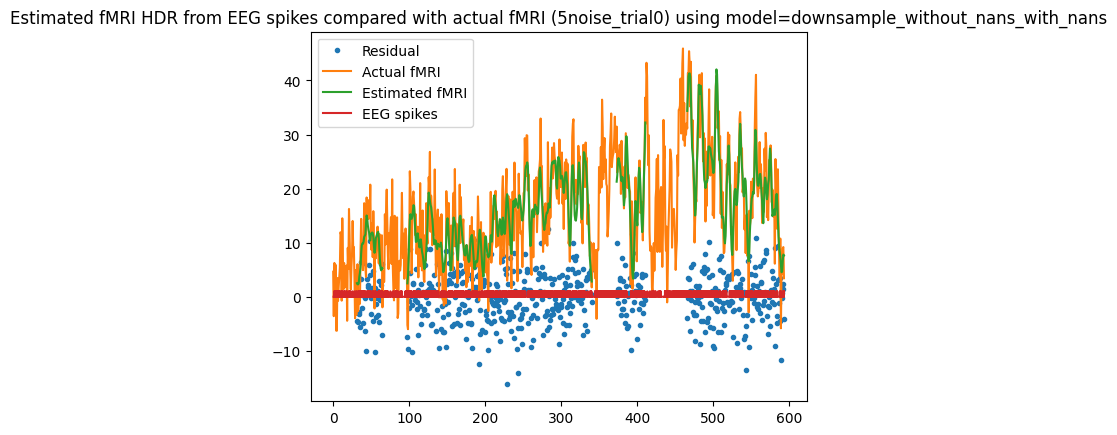

Residual Variance is 21.587290


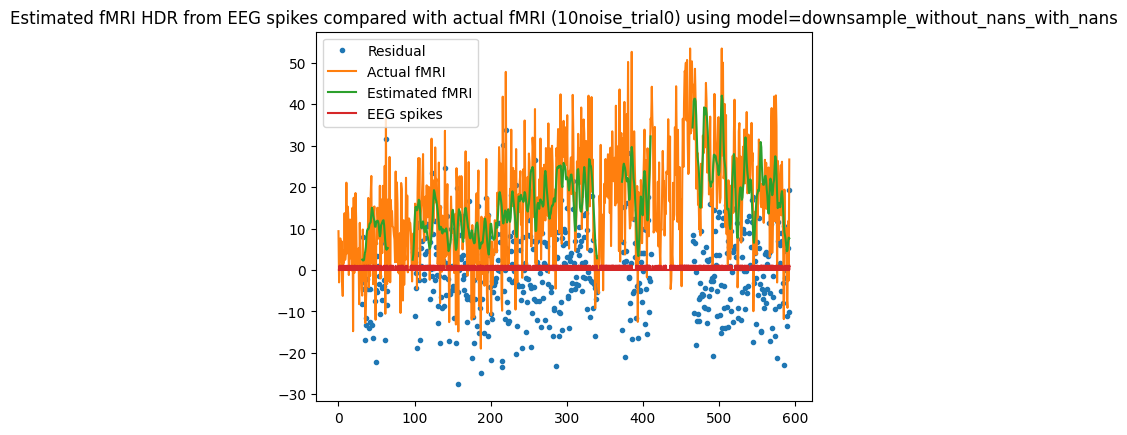

Residual Variance is 102.915297


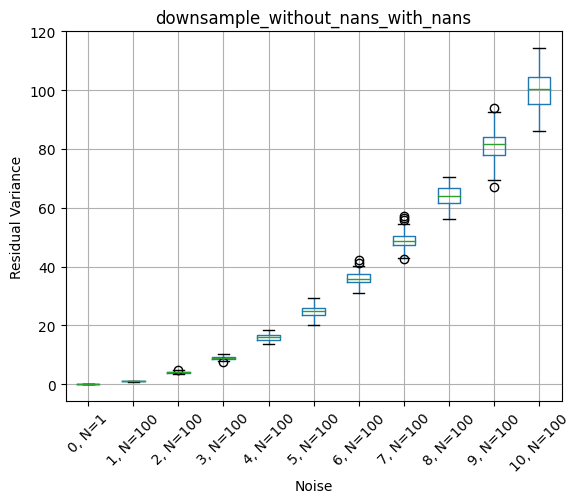

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name       0noise_trial0  \
0      downsample_without_nans_without_nans   41.61979426598036   
1         downsample_without_nans_with_nans   38.07238346632758   
2      downsample_without_nans_without_nans  40.762875425924605   
3         downsample_without_nans_with_nans   37.33652408834901   
4      downsample_without_nans_without_nans   39.89790223958655   
...                                     ...                 ...   
18937     downsample_without_nans_with_nans  14.468366654116794   
18938  downsample_without_nans_without_nans   16.56013079678086   
18939     downsample_without_nans_with_nans  15.154581381093271   
18940  downsample_without_nans_without_nans  17.332590449587766   
18941     downsample_without_nans_with_nans  15.833261642881503   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0       43.43484492504276   45.83357456553528  51.534355152644714   
1       40.24376679440595   43.37977596949306   47.71933876708107   
2       42.57342246448871    44.9714540140805  50.644017895348924   
3      39.503598162864826   42.63153536671877    46.9551079419013   
4      41.703394027349276   44.10161509651713   49.74499906491942   
...                   ...                 ...                 ...   
18937   15.48271663394688  17.311615032852664  24.401606265499673   
18938   17.61732821109541  19.662430297341302  27.615249473150506   
18939  16.180004801000212  17.992557573150666   25.10797708454344   
18940  18.396589677788043  20.427303616721712  28.413232456205865   
18941   16.86998452697792   18.66755133618236  25.804844725564855   

            4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0       58.06628575753704     68.275472216522  ...  42.859278412061784   
1        55.9066289411028   62.06869853891631  ...  39.054662505880465   
2      57.188044309871934   67.36219259559877  ...   42.00220177875582   
3       55.13857665300995   61.22725655619512  ...  38.315559417814214   
4       56.30266931024006    66.4399077565557  ...   41.13706919785606   
...                   ...                 ...  ...                 ...   
18937  29.694743746782546   36.80288281759246  ...  15.334541368348214   
18938   32.31533801642072  38.695561533932725  ...  17.229913452183865   
18939  30.364037607957876   37.50320664342686  ...   16.01747797615619   
18940   33.09330195982124  39.480112039350985  ...   17.99801994056016   
18941  31.027713215114886   38.19688397615816  ...  16.693197163996242   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0      44.489023486123315   51.37810190126796   56.87357516340088   
1       40.83340510383633  47.862962426536605  53.451355615625424   
2        43.6399282391956   50.49225818346487   56.01222298999323   
3       40.10445591944504  47.088831230753364   52.72415991257819   
4       42.78349113498146   49.59814415263952  55.144957862029095   
...                   ...                 ...                 ...   
18937   18.27842412802119  24.002992445863455   30.52169152196362   
18938  20.616971687176292   25.29673550372098   32.80979716877943   
18939   18.95716147354568   24.68237127174327  

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 2.89013259463875e-28; at
       delta   tau  alpha
11778   2.25  1.25   1.95


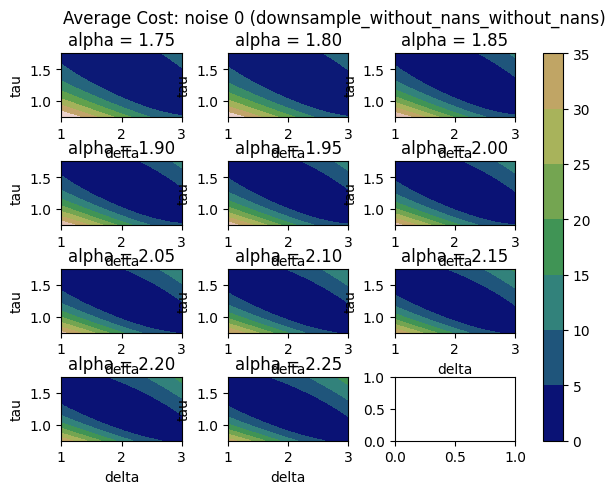

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                              41.619794             
2                                              40.762875             
4                                              39.897902             
6                                              39.025604             
8                                              38.146734             
...                                                  ...             
18932                                          14.216021             
18934                                          15.000582             
18936                                          15.782392             
18938                                          16.560131             
18940                                          17.332590             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.25, Alpha target: 1.95


delta   tau  alpha
0   2.25  1.25   1.95

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.25, Alpha target: 1.95


noise iteration          cost  delta   tau  alpha
0      0         0  3.484966e-03   2.20  1.20   2.10
1      0         0  2.890133e-28   2.25  1.25   1.95
2      0         0  5.882861e-03   2.30  1.30   1.80

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 1.0691098044750027e-28; at
       delta   tau  alpha
11779   2.25  1.25   1.95


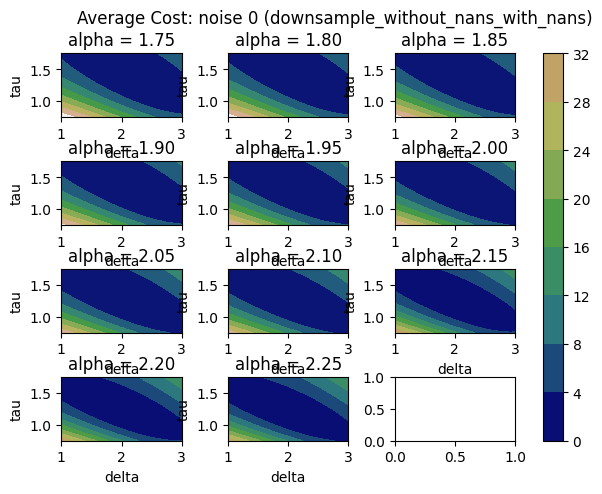

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                              38.072383          
3                                              37.336524          
5                                              36.590852          
7                                              35.835971          
9                                              35.072514          
...                                                  ...          
18933                                          13.077752          
18935                                          13.775693          
18937                                          14.468367          
18939                                          15.154581          
18941                                          15.833262          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.25, Alpha target: 1.95


delta   tau  alpha
0   2.25  1.25   1.95

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.25, Alpha target: 1.95


noise iteration          cost  delta   tau  alpha
0      0         0  3.455104e-03   2.20  1.20   2.10
1      0         0  1.069110e-28   2.25  1.25   1.95
2      0         0  5.926549e-03   2.30  1.30   1.80

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 0.9975970487019817; at
       delta   tau  alpha
11778   2.25  1.25   1.95


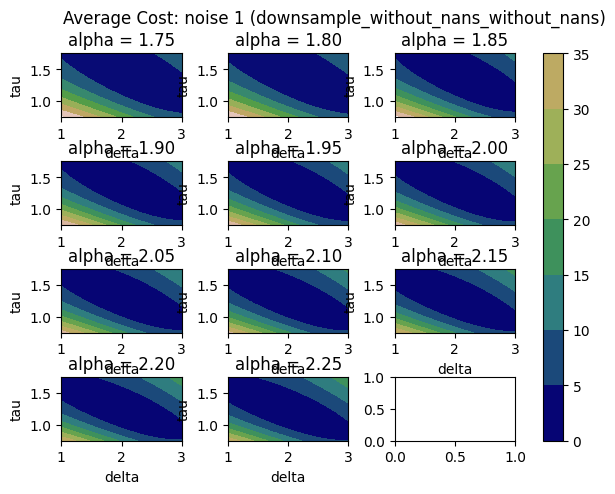

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 4.050511513925783; at
       delta   tau  alpha
11778   2.25  1.25   1.95


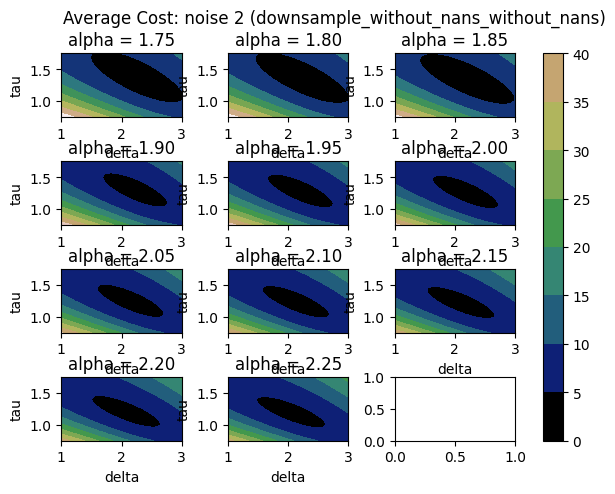

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 9.023630938259261; at
       delta   tau  alpha
11778   2.25  1.25   1.95


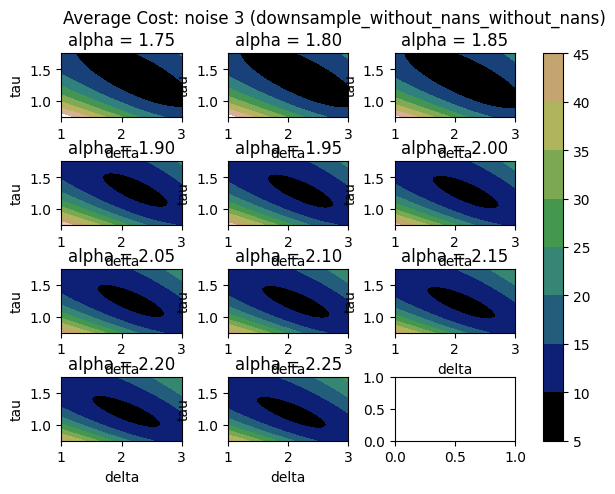

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 15.978250284540318; at
       delta   tau  alpha
11778   2.25  1.25   1.95


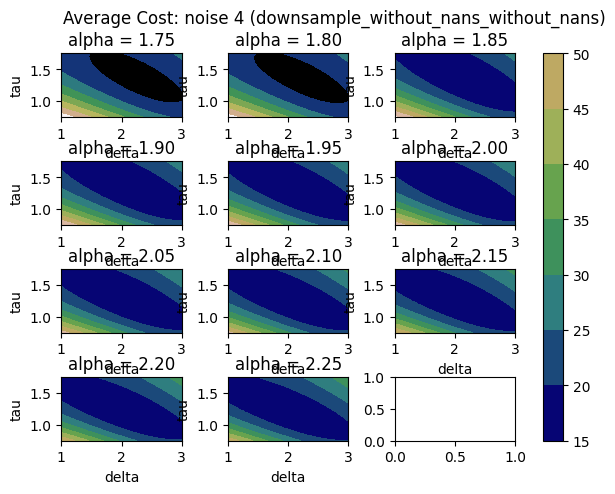

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 24.81988151480029; at
       delta   tau  alpha
11318    2.2  1.25    2.0


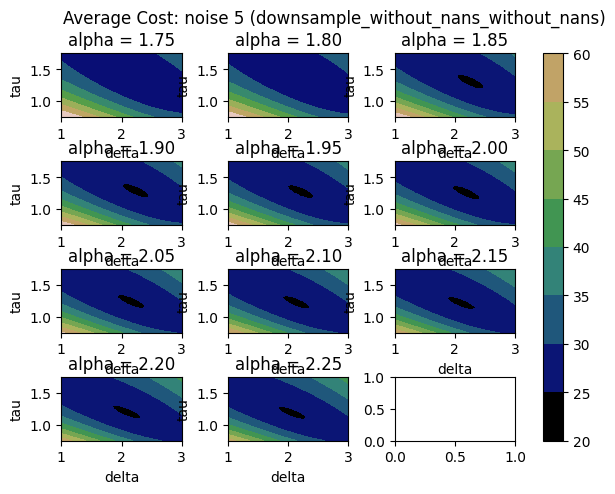

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 36.06095266349638; at
       delta   tau  alpha
11778   2.25  1.25   1.95


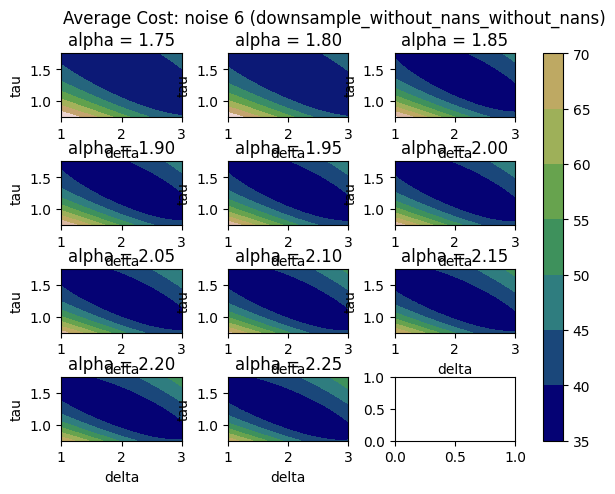

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 48.91606795886095; at
       delta  tau  alpha
12256    2.3  1.3    1.8


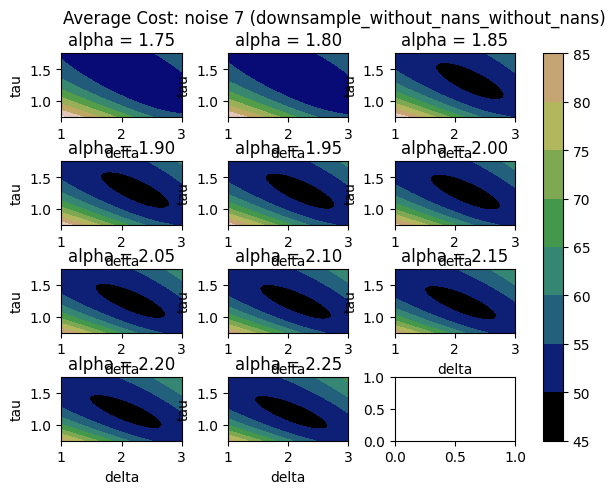

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 63.932379033777515; at
       delta   tau  alpha
11778   2.25  1.25   1.95


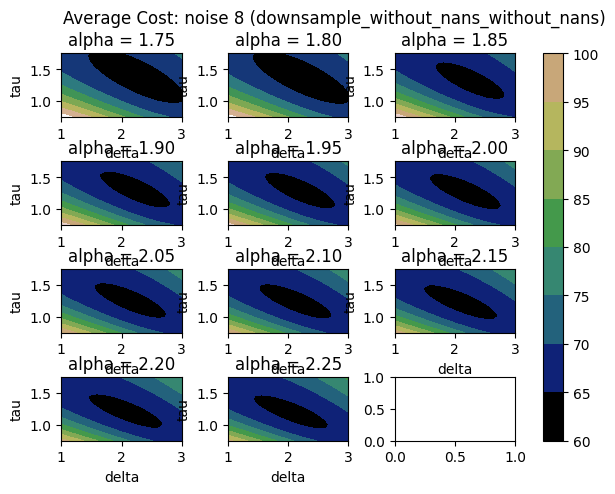

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 81.26469822389768; at
       delta  tau  alpha
12256    2.3  1.3    1.8


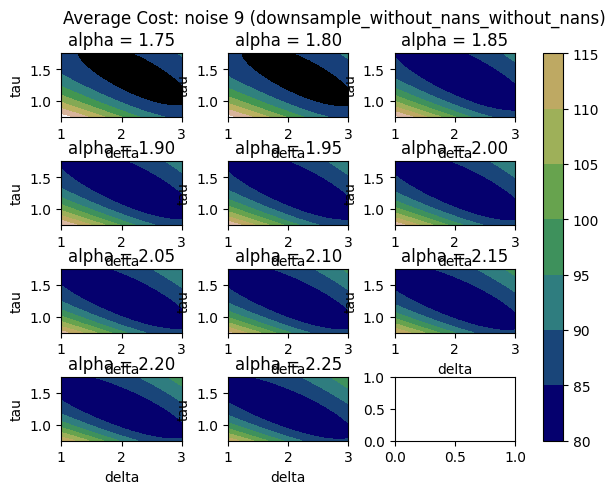

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 99.97913446086385; at
       delta   tau  alpha
12238    2.3  1.25    1.9


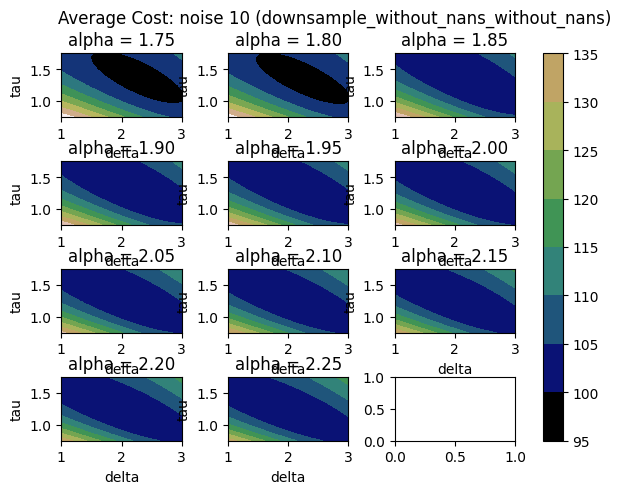

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

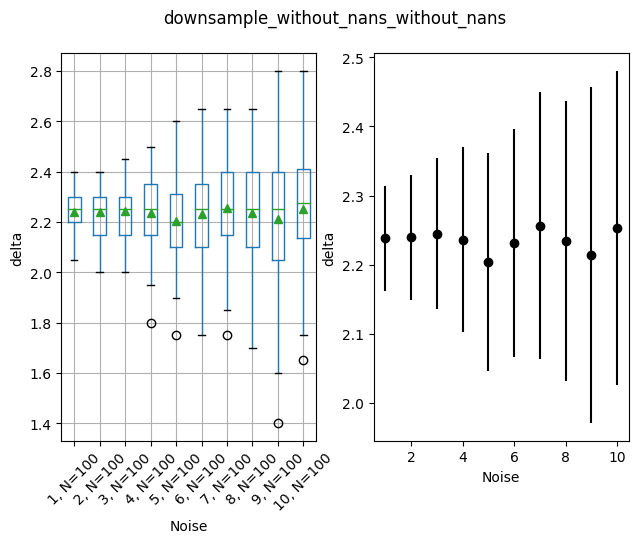

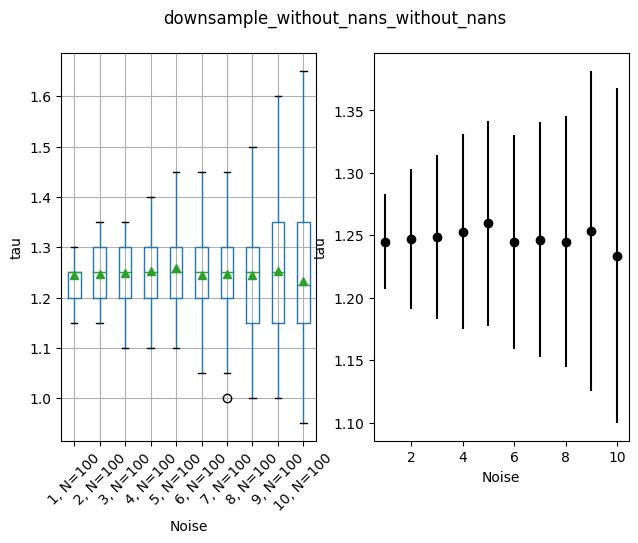

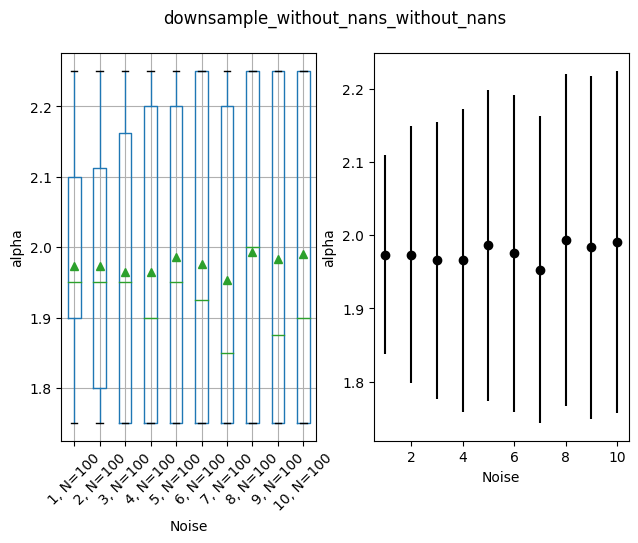

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 0.998034500432442; at
       delta   tau  alpha
11779   2.25  1.25   1.95


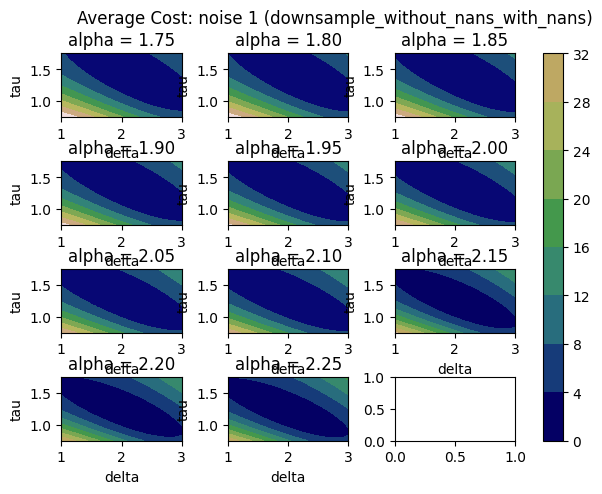

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 4.045187869142661; at
       delta   tau  alpha
11779   2.25  1.25   1.95


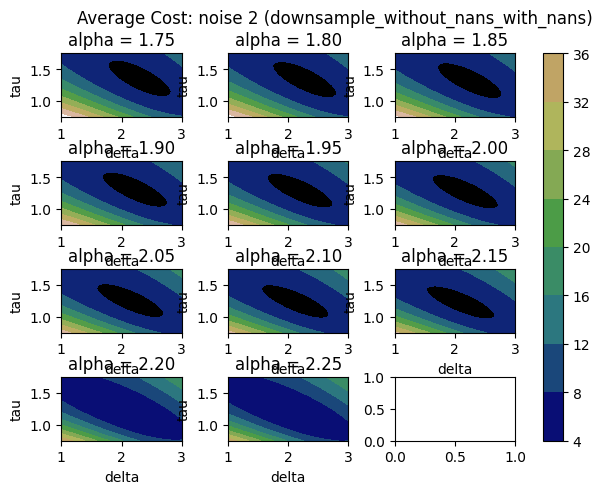

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 9.017566472377311; at
       delta   tau  alpha
11779   2.25  1.25   1.95


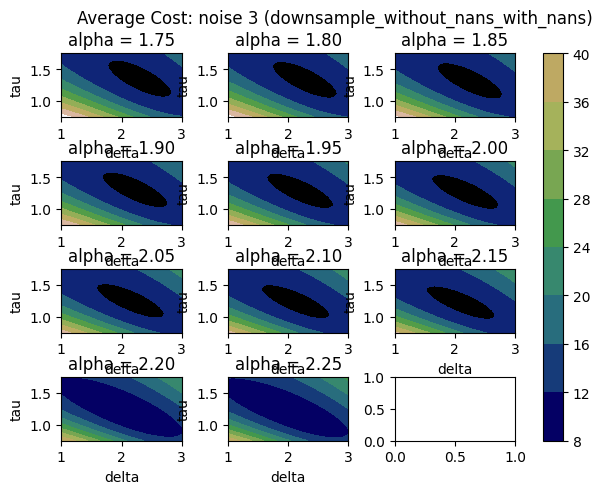

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 15.950350204358877; at
       delta   tau  alpha
11779   2.25  1.25   1.95


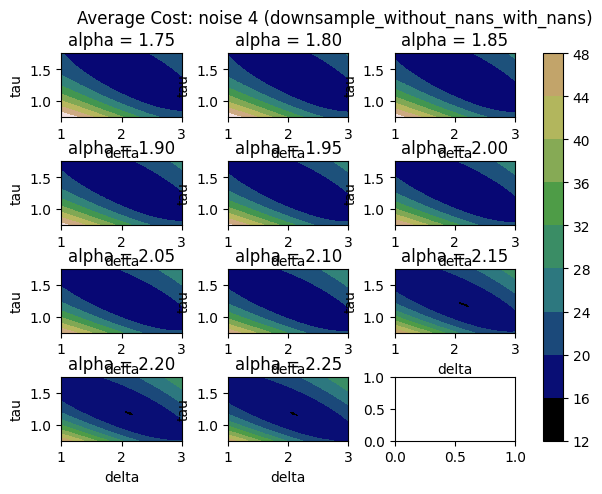

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 24.806347353243627; at
       delta   tau  alpha
11319    2.2  1.25    2.0


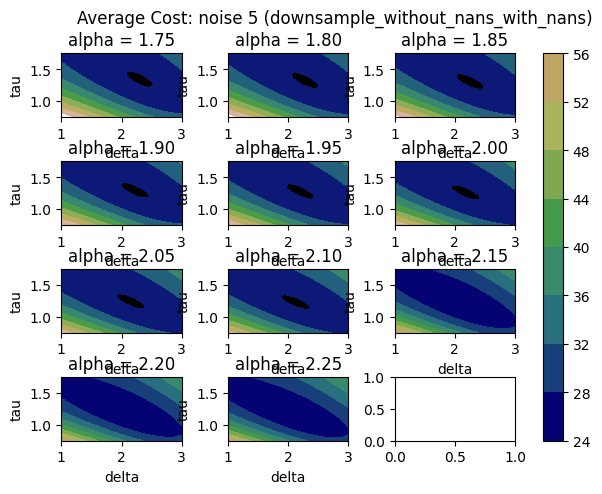

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 36.01846031844797; at
       delta  tau  alpha
10839   2.15  1.2    2.1


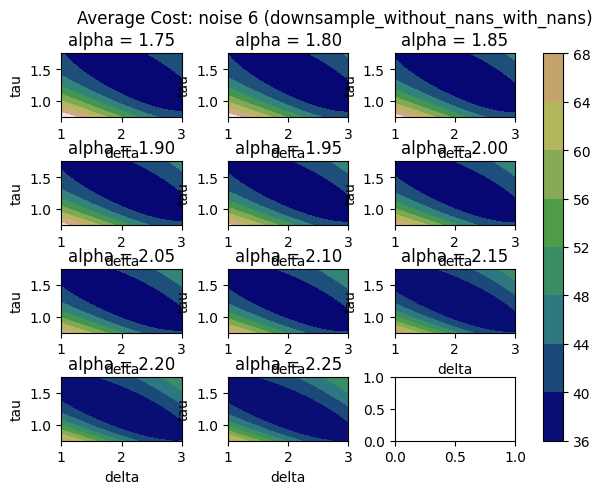

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 48.842065524380715; at
       delta  tau  alpha
12257    2.3  1.3    1.8


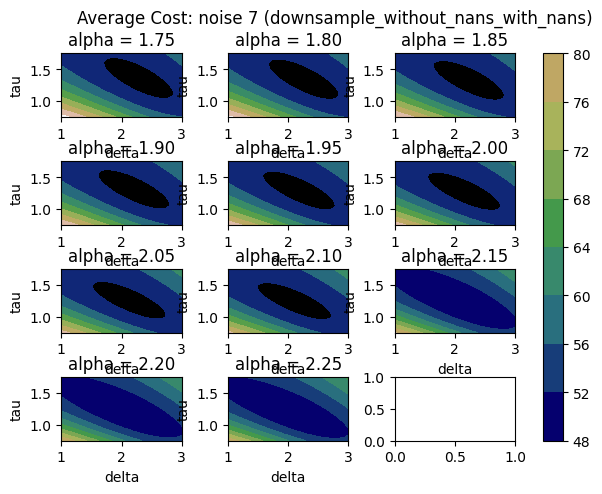

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 64.05742883635413; at
       delta  tau  alpha
12719   2.35  1.3    1.8


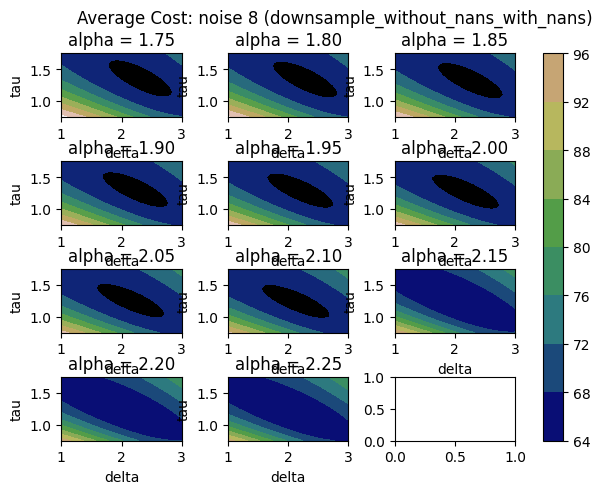

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 81.33420327547843; at
       delta  tau  alpha
12257    2.3  1.3    1.8


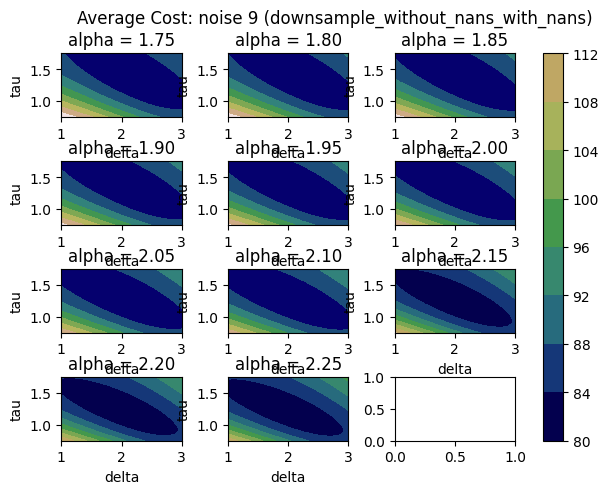

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 99.79818811662554; at
       delta   tau  alpha
12239    2.3  1.25    1.9


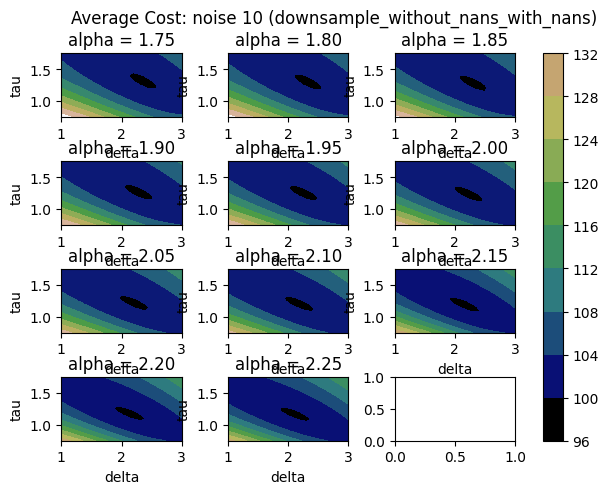

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


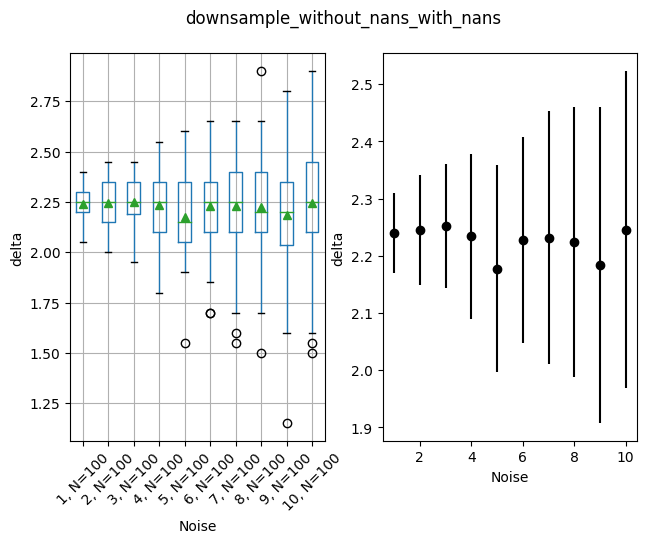

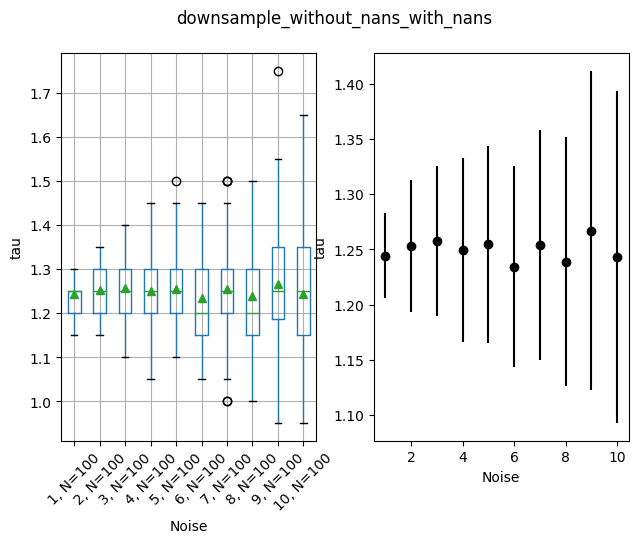

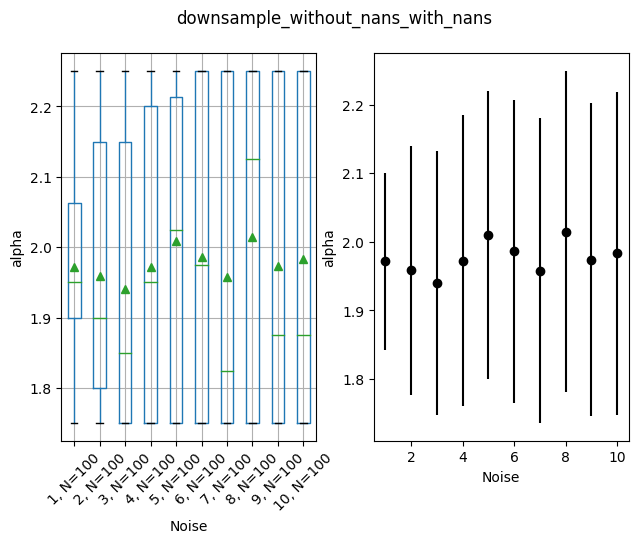

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        20    1.008017  2.0500000000000007  1.2000000000000004   
1         1        28    0.953666   2.100000000000001  1.1500000000000004   
2         1        35    1.090423   2.100000000000001  1.1500000000000004   
3         1        38    0.995922   2.100000000000001  1.1500000000000004   
4         1        41    1.087040   2.100000000000001  1.1500000000000004   
...     ...       ...         ...                 ...                 ...   
2666     10        36  103.472603  2.7000000000000015  0.9500000000000002   
2667     10        38  100.703696  2.7000000000000015  1.0500000000000003   
2668     10        36  103.469011  2.8000000000000016  1.0000000000000002   
2669     10        38  100.702365  2.8000000000000016  1.1000000000000003   
2670     10        36  103.478247  2.8500000000000014  1.0500000000000003   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2666  2.2500000000000004  
2667  2.0500000000000003  
2668                 2.0  
2669                1.85  
2670                1.85  

[2671 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  3.50  0.522233  2.0  3.0  4.0  4.0  4.0
2                      100.0  3.42  0.638496  1.0  3.0  3.0  4.0  4.0
3                      100.0  3.19  0.837203  1.0  3.0  3.0  4.0  4.0
4                      100.0  2.75  0.967920  1.0  2.0  3.0  3.0  4.0
5                      100.0  2.76  1.035921  1.0  2.0  3.0  4.0  4.0
6                      100.0  2.47  1.149923  1.0  1.0  3.0  3.0  4.0
7                      100.0  2.28  1.137781  1.0  1.0  2.0  3.0  4.0
8                      100.0  2.35  1.175293  1.0  1.0  2.5  3.0  4.0
9                      100.0  2.05  1.095215  1.0  1.0  2.0  3.0  4.0
10                     100.0  1.94  1.013246  1.0  1.0  2.0  3.0  4.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
302       1         2    1.047941   2.300000000000001  1.3500000000000005   
303       1        17    0.933379   2.300000000000001  1.3500000000000005   
304       1        20    1.020999   2.300000000000001  1.3500000000000005   
305       1        22    0.980491   2.300000000000001  1.3500000000000005   
306       1        73    0.994772   2.300000000000001  1.3500000000000005   
...     ...       ...         ...                 ...                 ...   
2658     10         5   94.590199  2.6000000000000014  1.1500000000000004   
2660     10        14  100.166688  2.6000000000000014  1.2000000000000004   
2663     10        15  102.529069  2.6500000000000012  1.2000000000000004   
2664     10        56   97.068089  2.6500000000000012  1.2000000000000004   
2665     10        94  108.448211  2.6500000000000012  1.3000000000000005   

     alpha  
302   1.75  
303   1.75  
304   1.75  
305   1.75  
306   1.75  
...    ...  
2658  1.75  
2660  1.75  
2663  1.75  
2664  1.75  
2665  1.75  

[440 rows x 6 columns]

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        21      3  2.3500000000000014    8    21      2  1.3000000000000005   
10       51     15   2.450000000000001    8    51      9  1.3000000000000005   
2        35      5   2.300000000000001   12    35      2  1.3000000000000005   
3        47      6  2.4000000000000012   15    47      4  1.3000000000000005   
4        43      8   2.300000000000001   12    43      5  1.3000000000000005   
5        40     10  2.3500000000000014    9    40      6  1.3500000000000005   
6        50     12  2.3500000000000014   11    50      6  1.3000000000000005   
7        50     11  2.3500000000000014   10    50      7  1.2500000000000004   
8        52     14  2.4000000000000012    9    52      7  1.3000000000000005   
9        51     16   2.250000000000001    7    51     10  1.3000000000000005   

            
      freq  
noise       
1       15  
10      10  
2       19  
3       24  
4       18  
5       11  
6       19  
7       13  
8       16  
9       11

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1        20    1.008017  2.0500000000000007  1.2000000000000004   
1         1        28    0.953666   2.100000000000001  1.1500000000000004   
2         1        35    1.090423   2.100000000000001  1.1500000000000004   
3         1        38    0.995922   2.100000000000001  1.1500000000000004   
4         1        41    1.087040   2.100000000000001  1.1500000000000004   
...     ...       ...         ...                 ...                 ...   
2627     10        15  102.554208   2.450000000000001  1.0500000000000003   
2628     10        72   97.708772   2.450000000000001  1.0500000000000003   
2647     10        86  101.345280  2.5500000000000016  0.9500000000000002   
2657     10        38  100.702259  2.6000000000000014  1.0000000000000002   
2666     10        36  103.472603  2.7000000000000015  0.9500000000000002   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2627  2.2500000000000004  
2628  2.2500000000000004  
2647  2.2500000000000004  
2657  2.2500000000000004  
2666  2.2500000000000004  

[408 rows x 6 columns]

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        46      3  2.1500000000000012   34    46      2  1.1500000000000004   
10       49     19   2.100000000000001    6    49     10  1.1500000000000004   
2        42      5  2.1500000000000012   18    42      2  1.1500000000000004   
3        36      6  2.1500000000000012   14    36      3  1.1500000000000004   
4        33     11  2.0500000000000007   10    33      6  1.1500000000000004   
5        37     10  2.1500000000000012    9    37      6  1.1500000000000004   
6        38     10   2.000000000000001    7    38      5  1.1500000000000004   
7        33     11   2.100000000000001    7    33      6  1.2000000000000004   
8        43     15   2.100000000000001    9    43      8  1.2000000000000004   
9        51     21   2.200000000000001    6    51      9  1.2000000000000004   

            
      freq  
noise       
1       45  
10      12  
2       36  
3       24  
4       16  
5       18  
6       20  
7       11  
8       13  
9       12

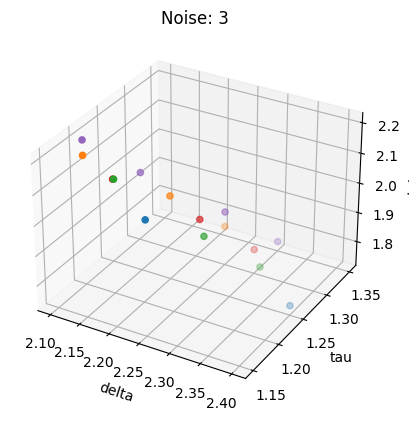

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

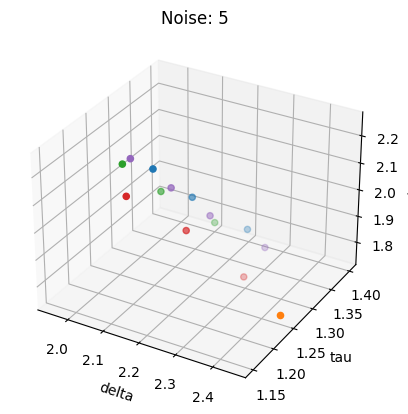

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

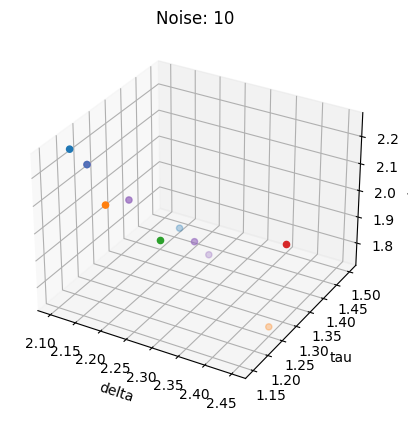

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        42    1.007059  2.0500000000000007  1.2000000000000004   
1         1        17    0.962273  2.0500000000000007  1.2000000000000004   
2         1        20    1.049021  2.0500000000000007  1.2000000000000004   
3         1         9    1.003694   2.100000000000001  1.1500000000000004   
4         1        28    0.972870   2.100000000000001  1.1500000000000004   
...     ...       ...         ...                 ...                 ...   
2551     10        72   96.185200  2.7500000000000018  1.0000000000000002   
2552     10        70   92.329476  2.8000000000000016  1.1000000000000003   
2553     10        72   96.201577  2.8500000000000014  1.0500000000000003   
2554     10        36  105.443134  2.9000000000000017  1.1000000000000003   
2555     10        72   96.225576  2.9000000000000017  1.1000000000000003   

                   alpha  
0                    2.2  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2551  2.1500000000000004  
2552                1.75  
2553  1.9000000000000001  
2554                1.75  
2555                1.75  

[2556 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  3.55  0.538891  2.0  3.0  4.0  4.0  4.0
2                      100.0  3.30  0.797724  1.0  3.0  3.0  4.0  4.0
3                      100.0  3.02  0.931817  1.0  3.0  3.0  4.0  4.0
4                      100.0  2.69  1.070212  1.0  2.0  3.0  4.0  4.0
5                      100.0  2.59  1.101835  1.0  2.0  3.0  3.0  4.0
6                      100.0  2.32  1.144861  1.0  1.0  2.0  3.0  4.0
7                      100.0  2.25  1.183856  1.0  1.0  2.0  3.0  4.0
8                      100.0  2.05  1.067187  1.0  1.0  2.0  3.0  4.0
9                      100.0  2.04  1.109372  1.0  1.0  2.0  3.0  5.0
10                     100.0  1.75  1.057680  1.0  1.0  1.0  2.0  5.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

noise iteration       cost               delta                 tau alpha
2184      9        71  75.638144  1.6500000000000006  1.7500000000000009  1.85

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
309       1        11    0.877676   2.300000000000001  1.3500000000000005   
310       1        17    0.957603   2.300000000000001  1.3500000000000005   
311       1        20    1.060206   2.300000000000001  1.3500000000000005   
312       1        22    0.972541   2.300000000000001  1.3500000000000005   
313       1        59    1.034888   2.300000000000001  1.3500000000000005   
...     ...       ...         ...                 ...                 ...   
2548     10        94  104.635130  2.7000000000000015  1.2500000000000004   
2550     10        12   90.148215  2.7500000000000018  1.0000000000000002   
2552     10        70   92.329476  2.8000000000000016  1.1000000000000003   
2554     10        36  105.443134  2.9000000000000017  1.1000000000000003   
2555     10        72   96.225576  2.9000000000000017  1.1000000000000003   

     alpha  
309   1.75  
310   1.75  
311   1.75  
312   1.75  
313   1.75  
...    ...  
2548  1.75  
2550  1.75  
2552  1.75  
2554  1.75  
2555  1.75  

[435 rows x 6 columns]

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        23      3  2.3500000000000014   11    23      2  1.3000000000000005   
10       51     18  2.5500000000000016    8    51     14  1.2500000000000004   
2        41      5  2.3500000000000014   18    41      3  1.3000000000000005   
3        46      7  2.3500000000000014   19    46      4  1.3500000000000005   
4        45      9   2.300000000000001   12    45      5  1.3000000000000005   
5        39     13  2.3500000000000014    8    39      7  1.3000000000000005   
6        44     12   2.450000000000001    8    44      6  1.3000000000000005   
7        52     13   2.250000000000001   10    52      8  1.2500000000000004   
8        44     14  2.5000000000000013    8    44      9  1.3000000000000005   
9        50     17   2.200000000000001    8    50     10  1.4000000000000006   

            
      freq  
noise       
1       17  
10       8  
2       25  
3       22  
4       21  
5       12  
6       13  
7       14  
8       12  
9       11

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
1         1        17    0.962273  2.0500000000000007  1.2000000000000004   
2         1        20    1.049021  2.0500000000000007  1.2000000000000004   
3         1         9    1.003694   2.100000000000001  1.1500000000000004   
4         1        28    0.972870   2.100000000000001  1.1500000000000004   
5         1        33    0.964073   2.100000000000001  1.1500000000000004   
...     ...       ...         ...                 ...                 ...   
2528     10        52  109.205903  2.5500000000000016  1.0500000000000003   
2529     10        90  105.991586  2.5500000000000016  1.0500000000000003   
2538     10        86   99.679237  2.6000000000000014  0.9500000000000002   
2543     10        70   92.391056  2.6500000000000012  0.9500000000000002   
2549     10        72   96.187787  2.7500000000000018  0.9500000000000002   

                   alpha  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
5     2.2500000000000004  
...                  ...  
2528  2.2500000000000004  
2529  2.2500000000000004  
2538  2.2500000000000004  
2543  2.2500000000000004  
2549  2.2500000000000004  

[431 rows x 6 columns]

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        51      4  2.1500000000000012   37    51      2  1.1500000000000004   
10       46     22  2.4000000000000012    5    46     10  1.1500000000000004   
2        34      5  2.1500000000000012   16    34      2  1.1500000000000004   
3        35      8  2.1500000000000012    8    35      3  1.1500000000000004   
4        33      9   2.100000000000001   11    33      4  1.1500000000000004   
5        41     11   2.100000000000001    9    41      7  1.2000000000000004   
6        44     15   2.100000000000001    9    44      6  1.1500000000000004   
7        44     18   2.000000000000001    5    44      9  1.2000000000000004   
8        54     18   2.100000000000001    8    54      9  1.1500000000000004   
9        49     18  2.0500000000000007    7    49      9  1.2500000000000004   

            
      freq  
noise       
1       49  
10       8  
2       27  
3       16  
4       19  
5       13  
6       16  
7       15  
8       16  
9        9

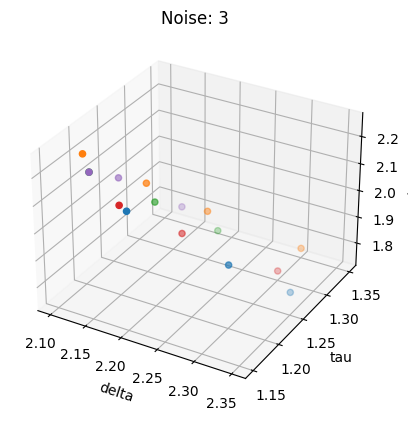

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

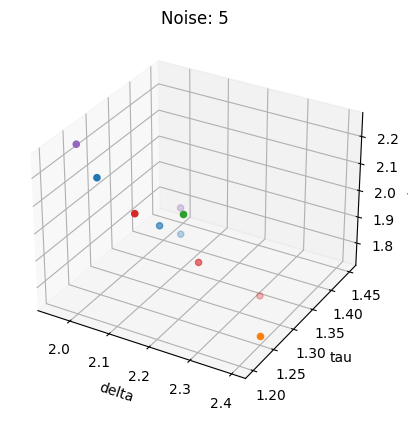

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

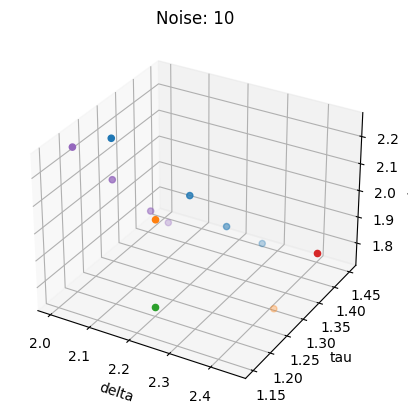

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()